# Reddit clustering exercise

Extract insights from the social media content, based on a month of Reddit data.

Address the following tasks: 

* A basic exploration of the data. 
* List of ideas that popped into your head during your exploration. Everything that you think is interesting to explore should be here. 
* Use topic clustering/modeling methods, in order to cluster Reddit’s/words. Then use these topics overtime to find interesting events in the data. In this part don’t use the “subreddit” column.
* Evaluate your Reddits topic clustering/modeling results using the “subreddit” column (as tagged data for Reddit’s topic).
* Use methods for data cleaning.

In [1]:
!pip install cluster
!pip install -U sentence-transformers
!pip install umap-learn hdbscan
!pip install plotly==5.6.0 
!pip install pyyaml==5.4.1
!pip install -U pandas
!pip install -U jupyter ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 4.7 MB 49.9 MB/s 
     |████████████████████████████████| 1.3 MB 60.4 MB/s 
     |████████████████████████████████| 120 kB 69.5 MB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0ab38d5d0a8c0553cf6c6a47ffdd170f4cf5d670750f1c93ec02257430270d6a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████

In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import pickle

# Download data

In [3]:
!wget https://www.dropbox.com/s/czy80azezn19wib/Reddit_12_2008.csv.zip

--2022-08-31 17:58:06--  https://www.dropbox.com/s/czy80azezn19wib/Reddit_12_2008.csv.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/czy80azezn19wib/Reddit_12_2008.csv.zip [following]
--2022-08-31 17:58:07--  https://www.dropbox.com/s/raw/czy80azezn19wib/Reddit_12_2008.csv.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9c6e6e69c49897abcb8a3063b4.dl.dropboxusercontent.com/cd/0/inline/BsEEyRmzCionVaqddLqKVkn0sr8Wgm-abLtYRjLhknJQtsGvCB1JWZIKoLM_boOivkvD62PiBanlV9644O3QnKcmgF3tEWGUUPZCY1cwkoyYd7gmrQtpWdQRYDAGpAc0A021lWz6u8phhSRhzrw31AbWo4yB_wFhdQTCvwH7NKG-jg/file# [following]
--2022-08-31 17:58:07--  https://uc9c6e6e69c49897abcb8a3063b4.dl.dropboxusercontent.com/cd/0/inline/BsEEyRmzCionVaqddLqKVkn0sr8Wgm-abLtYRjLhknJQtsG

In [4]:
!unzip -o Reddit_12_2008.csv.zip 

Archive:  Reddit_12_2008.csv.zip
  inflating: Reddit_12_2008.csv      
  inflating: __MACOSX/._Reddit_12_2008.csv  


In [5]:
df = pd.read_csv('Reddit_12_2008.csv')#.sample(50_000, random_state=7)
df

,author,body,created_utc,subreddit,id,score
0,malcontent,&gt;The business cannot survive paying out ben...,2008-12-18 08:00:37,politics,2,1
1,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:41,politics,3,1
2,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:53,politics,4,2
3,[deleted],[deleted],2008-12-18 08:01:07,WTF,5,1
4,catalytica,The greatest historic instigator of human divi...,2008-12-18 08:01:20,atheism,7,0
...,...,...,...,...,...,...
558348,[deleted],"Yeah, seriously. If anything it ""revalues"" mus...",2008-12-18 07:54:35,Music,c06vwuf,12
558349,Morgin_Black,"yes, beat it at failing.",2008-12-18 07:54:39,comics,c06vwug,0
558350,[deleted],Yes. This DRM will have the ability to send s...,2008-12-18 07:54:40,Economics,c06vwuh,1
558351,onezerozeroone,"To be fair, I think the original poster meant ...",2008-12-18 07:54:45,atheism,c06vwui,1


retain only 50K posts, for compactness and speed

In [6]:
df = df.head(50_000)

# Explore the data
A basic exploration of the data. List of ideas that popped into your head during your exploration. Everything that you think is interesting to explore should be here. 

## set dtypes

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       50000 non-null  object
 1   body         50000 non-null  object
 2   created_utc  50000 non-null  object
 3   subreddit    50000 non-null  object
 4   id           50000 non-null  object
 5   score        50000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.3+ MB


In [8]:
df =   df.convert_dtypes()
df['created_utc'] = pd.to_datetime( df.created_utc)
df['subreddit'] = df.subreddit.astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   author       50000 non-null  string        
 1   body         50000 non-null  string        
 2   created_utc  50000 non-null  datetime64[ns]
 3   subreddit    50000 non-null  category      
 4   id           50000 non-null  string        
 5   score        50000 non-null  Int64         
dtypes: Int64(1), category(1), datetime64[ns](1), string(3)
memory usage: 2.0 MB


## lets look at some asppects of the body, like its length



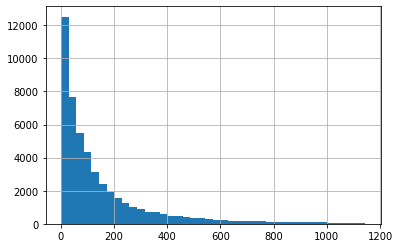

In [9]:
body_len = df.body.str.len()
body_len[body_len < body_len.quantile(0.98)].hist(bins=40)

In [10]:
df.body.describe()

count         50000
unique        42915
top       [deleted]
freq           6717
Name: body, dtype: object

looks like lots of bodies are suspiciously short, and uninformative. So we should delete all the "[deleted]" and "[[citation needed]" posts. If, later, we get into trouble clustering, we should revisit this step, and perhaps filter out more uninformative posts.

In [11]:
df = df.drop(df[df.body.str.len() <= 20].index)

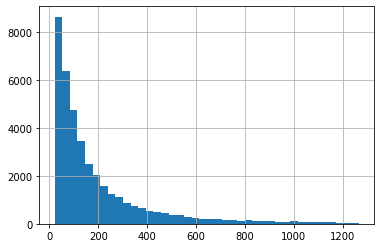

In [12]:
body_len = df.body.str.len()
body_len[body_len < body_len.quantile(0.98)].hist(bins=40)

In [13]:
df.body.describe()

count                                                 39917
unique                                                39764
top       The orignal poster, “reddit-man” a.k.a. "abori...
freq                                                     18
Name: body, dtype: object

Now, that looks a lot more normal

## are there any nulls?

In [14]:
df.isna().sum()

author         0
body           0
created_utc    0
subreddit      0
id             0
score          0
dtype: int64

if so, remove the nulls

In [15]:
df = df.dropna()

## observe most frequent values of the categoricals

In [16]:
import matplotlib.pyplot as plt


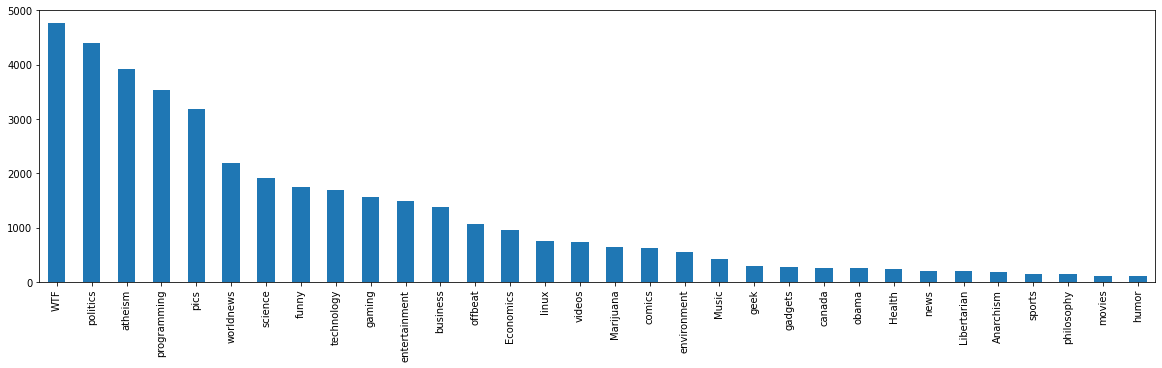

In [17]:
df.subreddit.value_counts().plot(ax=plt.subplots()[1], figsize=(20,5), kind='bar')

Looks like there's a long tail of subreddits. 

Since this is a target column, for simplicity, let's drop posts of rare subreddits, those that constitute < 1% of the dataset.

In [18]:
N = df.shape[0]
print(f'total posts == {N}, # subreddits == {df.subreddit.unique().shape[0]}')
min_freq = N // 100
print(f'removing posts of subreddits with less than {min_freq} posts')
vc = df.subreddit.value_counts()
subreddits_to_retain = set(vc[vc > min_freq].index)
df = df.loc[df.subreddit.isin(subreddits_to_retain), :]
new_N = df.shape[0]
print(f'The new # total posts == {new_N}')
n_target_clusters = len(subreddits_to_retain)
print(f'Now {n_target_clusters} non-rare subreddits remain.')
print(f'They are: {subreddits_to_retain}')

df['subreddit'] = df.loc[:,'subreddit'].astype("string").astype("category")

total posts == 39917, # subreddits == 32
removing posts of subreddits with less than 399 posts
The new # total posts == 37498
Now 20 non-rare subreddits remain.
They are: {'worldnews', 'business', 'politics', 'entertainment', 'WTF', 'comics', 'atheism', 'science', 'funny', 'videos', 'pics', 'Marijuana', 'Economics', 'linux', 'gaming', 'offbeat', 'programming', 'technology', 'environment', 'Music'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


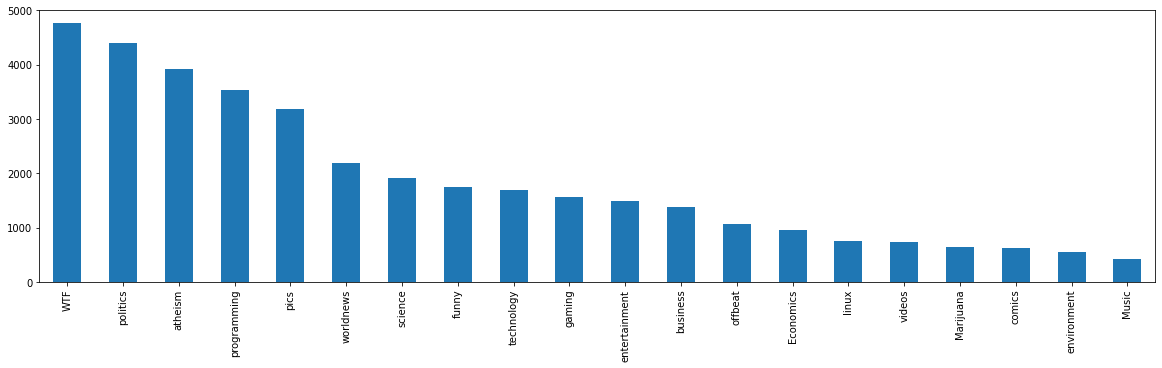

In [19]:
df.subreddit.value_counts().plot(ax=plt.subplots()[1], figsize=(20,5), kind='bar')

Looks like we've trimmed that long tail

## What is the average length of posts, broken by subreddit

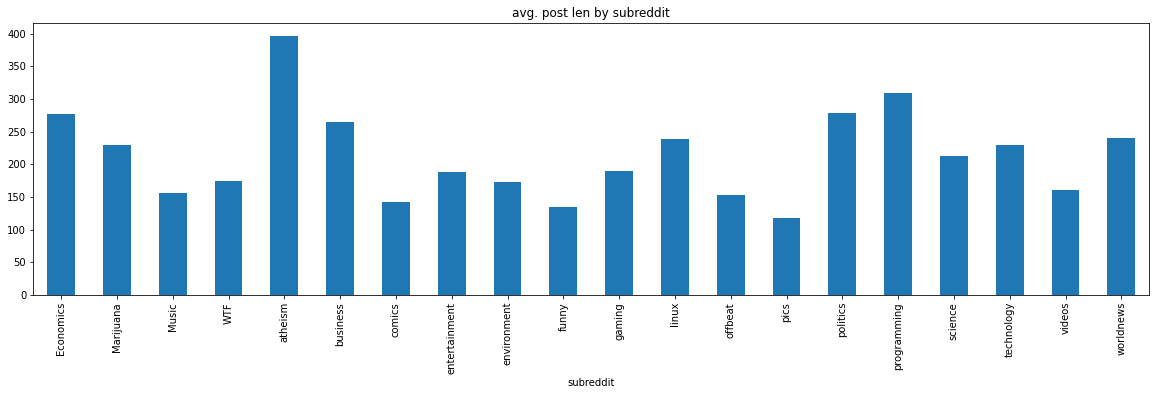

In [20]:
df.groupby('subreddit').agg({'body': lambda texts: texts.map(len).mean()}).body.plot.bar( figsize=(20, 5), 
                                                                                         title="avg. post len by subreddit")

Most posts are 100-200 chars long, which is short, like tweets. So further below we should consider tools that work well on short texts of social media.

Otherwise, this seems like a legitimate, fairly-uniform, distribution.

## Observe and get a feeling for  a sample of individual posts

use the interactive table feature (built in to colab) to filter and sort

In [21]:
df.sample(1000, random_state=7)[['body']]

,body
19466,"Jesus, I am usually a pretty calm, level-heade..."
4043,My shoe size also defines a part of who I am. ...
20684,You park like an asshole.
37696,"&gt;James 1:27 ""Pure and undefiled religion be..."
31001,DDR Mario edition fucking sucked. Like an ugly...
...,...
31094,I'm a said (F)ag and I am confused by your com...
21959,[That guy as a kid.](http://picayune.uclick.co...
7691,"non-free, do not want"
44144,[One link](http://uk.youtube.com/watch?v=b49Wo...


Seems like we will want to remove some common nonsensical tokens like "%gt;" and URLs. 
There's some slang and typos, but not much. So we might need to use a byte pair based embedding scheme, to embed the non standard languge, and we might do fine w/o that.

## Here's the distribution of "Score". not sure what this column means, so I have nothing to say

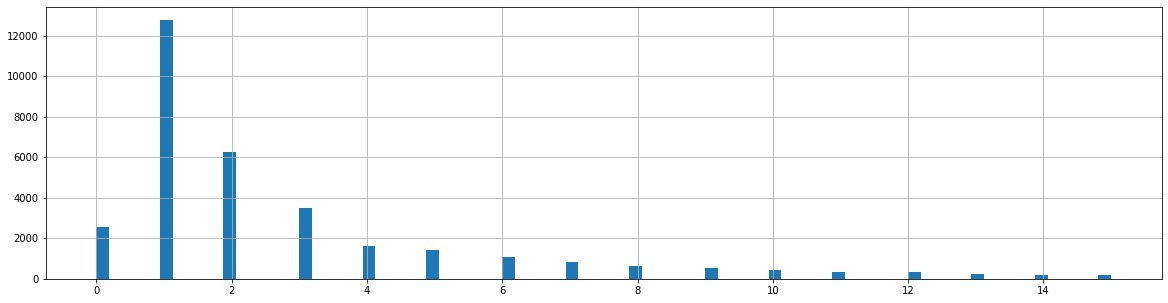

In [22]:
df[(df.score< df.score.quantile(0.95)) & (df.score > df.score.quantile(0.05)) ].score.hist(bins=80, figsize=(20, 5))

## look at stats on other columns

In [23]:
cols = df.columns.to_list()
cols.remove('score')
df[cols].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


,author,body,created_utc,subreddit,id
count,37498,37498,37498,37498,37498
unique,8172,37351,34270,20,37498
top,[deleted],"The orignal poster, “reddit-man” a.k.a. ""abori...",2008-12-18 23:01:44,WTF,2
freq,7769,18,4,4768,1
first,NaN,NaN,2008-12-18 08:00:37,NaN,NaN
last,NaN,NaN,2008-12-20 23:29:45,NaN,NaN


## look for some changes over time

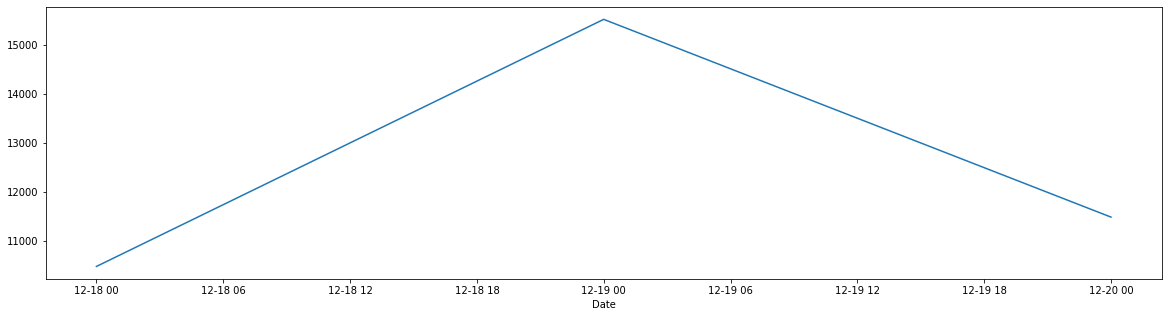

In [24]:
df.groupby(df['created_utc'].rename('Date').dt.date).size().plot(figsize=(20,5))

Looks like ppl post a lot at work, and post a little on wknds and holidays (xmas)

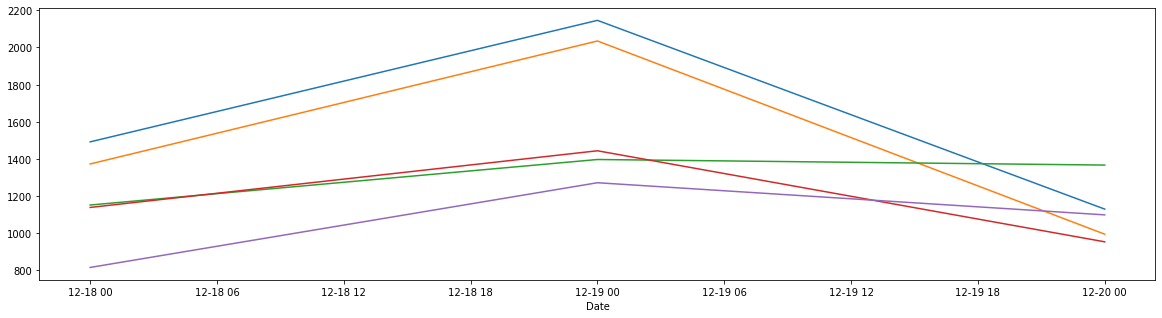

In [25]:
top_5_subreddits = df.subreddit.value_counts().index[:5].tolist()
top_5_subreddits
for subreddit in top_5_subreddits:
  df[df.subreddit==subreddit].groupby(df['created_utc'].rename('Date').dt.date).size().plot(figsize=(20,5))


Looks like the top 5 most popular subreddits follow the pattern as the whole, with some small variations and skews. we'll look deeper into time patterns below.

at what time do ppl post?

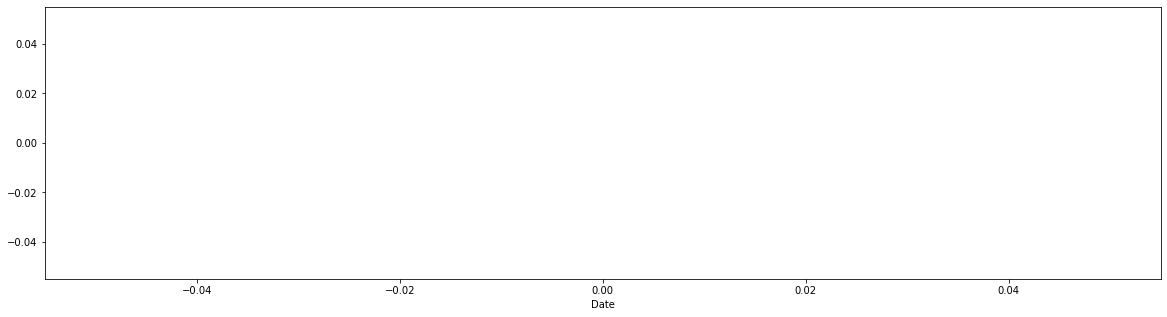

In [26]:
(df[(df.created_utc >= '2008-12-03') & (df.created_utc <= '2008-12-04')]
 .groupby(df['created_utc']
          .rename('Date').dt.hour)
 .size()
 .plot(figsize=(20,5)))

Seems like most posts occur between 17:00 and 01:00 UTC, so probably most authors live around the US west coast. 

## Look at author

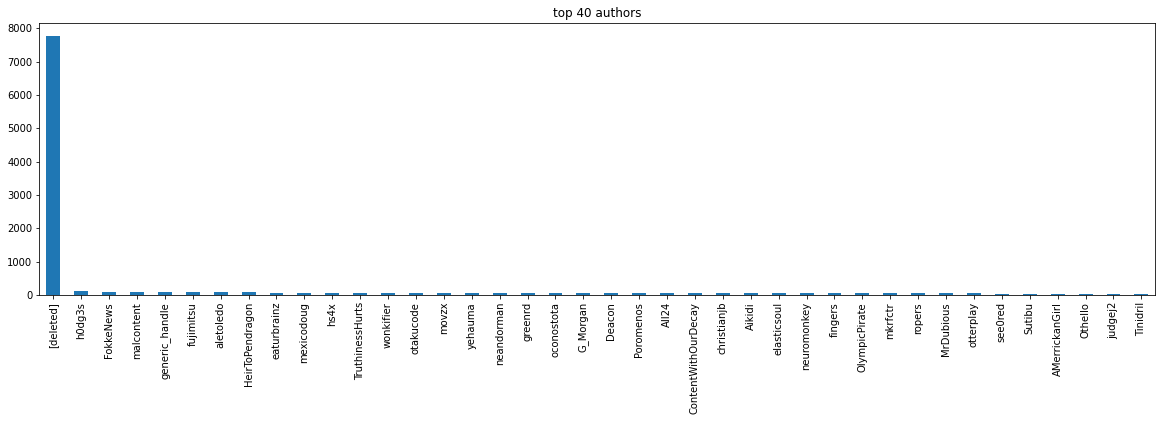

In [27]:
df.author.value_counts()[:40].plot(ax=plt.subplots()[1], 
                                   figsize=(20,5), 
                                   kind='bar',
                                   title='top 40 authors'
                                   )

Seems like most posts were made by users that have been deleted.

So what's the distribution of authors that are not "deleted"?

...Seems there's a long tail

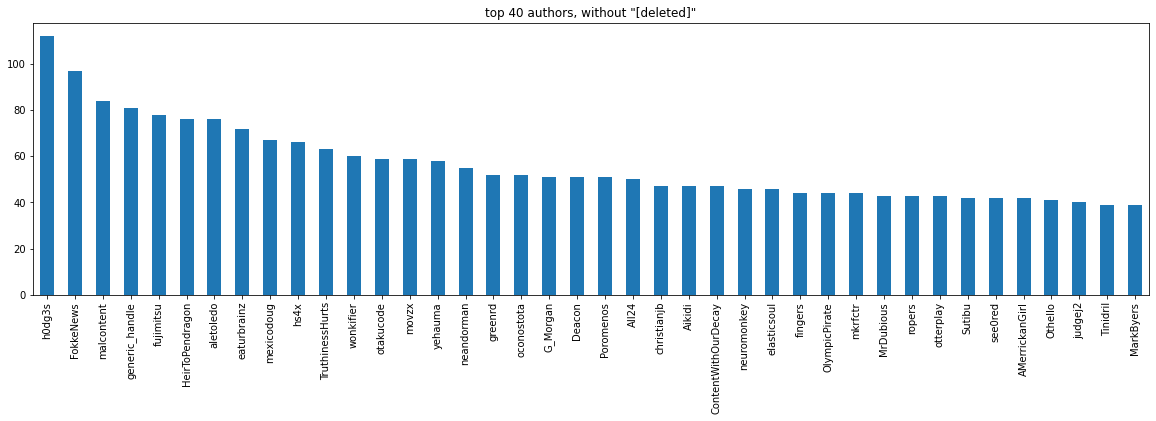

In [28]:
(df.author
 .drop(df[df.author == '[deleted]'].index).value_counts()[:40].plot(ax=plt.subplots()[1], 
                                                                    figsize=(20,5), 
                                                                    kind='bar',
                                                                    title='top 40 authors, without "[deleted]"'
                                                                    ))


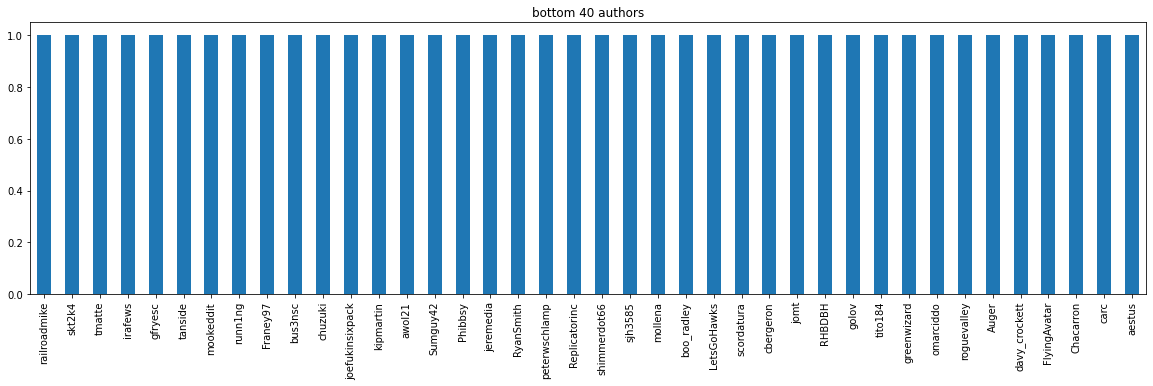

In [29]:
df['author'].drop(df[df.author == '[deleted]'].index).value_counts()
(df.author
 .drop(df[df.author == '[deleted]'].index).value_counts()[-40:].plot(ax=plt.subplots()[1], 
                                                                    figsize=(20,5), 
                                                                    kind='bar',
                                                                    title='bottom 40 authors'
                                                                    ))

## reset index, to keep tidy


In [30]:
df.reset_index(drop=True, inplace=True)

# Clean the text b4 embedding

remove URLs and "&" expressions

In [31]:
url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=;\\]*)'

# remove URLs, and stuff like numbers &gt;, &amb; ...
# TODO instead of removing all numbers, extract/label dates using a tool like duckling. 
df['body_clean'] = (df.body
                           .str.replace(url_pattern + r'|&\w?\w?\w?\w;|[\d\\/\[\]()]+', ' ', regex=True)
                          #  .str.replace(r'\W', ' ', regex=True)
                           )
df.sample(1000, random_state=7)[['body', 'body_clean']]

,body,body_clean
14736,"Jesus, I am usually a pretty calm, level-heade...","Jesus, I am usually a pretty calm, level-heade..."
2986,My shoe size also defines a part of who I am. ...,My shoe size also defines a part of who I am. ...
15612,You park like an asshole.,You park like an asshole.
28356,"&gt;James 1:27 ""Pure and undefiled religion be...","James : ""Pure and undefiled religion before..."
23314,DDR Mario edition fucking sucked. Like an ugly...,DDR Mario edition fucking sucked. Like an ugly...
...,...,...
23383,I'm a said (F)ag and I am confused by your com...,I'm a said F ag and I am confused by your com...
16545,[That guy as a kid.](http://picayune.uclick.co...,That guy as a kid.
5766,"non-free, do not want","non-free, do not want"
33160,[One link](http://uk.youtube.com/watch?v=b49Wo...,One link


# Use hdbscan, pic a LM on reddit social media text or short texts, based on byte code, maybe fastText. maybe BART trained on twitter?
evaluate manually, not with score. 
use at least 1K posts per topics

if all else fails, try hirarchical clustering

load a language model with sentence-transformers package

## embed the posts with a LM trained for text similarity, and fine tuned on reddit texts.

In [32]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('flax-sentence-embeddings/reddit_single-context_mpnet-base')
embeddings = model.encode(sentences)
print(embeddings.shape)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

(2, 768)


In [33]:
%%time
vecs = model.encode(df.body_clean.values)

CPU times: user 2min 21s, sys: 379 ms, total: 2min 22s
Wall time: 2min 20s


In [34]:
vecs.shape

(37498, 768)

## reduce dimensionality with UMAP, to improve clustering performance (see some explanation [here](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)), and cluster with HDBSCAN

In [35]:
%%time
import umap, hdbscan

import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

CPU times: user 12.4 s, sys: 314 ms, total: 12.7 s
Wall time: 13.7 s


In [36]:
%%time
vecs_umap = umap.UMAP(
    n_components=50,
    random_state=42,
).fit_transform(vecs)

CPU times: user 2min 27s, sys: 2.59 s, total: 2min 30s
Wall time: 2min 16s


In [37]:
# with open('vecs_umap.pickle', 'rb') as f:
#     vecs_umap = pickle.load(f)

In [38]:
vecs_umap.shape

(37498, 50)

In [39]:
with open('vecs_umap.pickle', 'wb') as f:
    pickle.dump(vecs_umap, f)

In [40]:
subreddit_code = df.subreddit.cat.codes

### lets plot the vectors on a reduced 2D space, cross-referencing with the subreddit labels.
This should give us an idea of how well the embedding separate vectors of different subreddits. 

In [41]:
%%time
vecs_umap2d = umap.UMAP(
    # n_neighbors=30,
    # min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(vecs)

with open('vecs_umap2d.pickle', 'wb') as f:
    pickle.dump(vecs_umap2d, f)

vecs_umap2d.shape

CPU times: user 52.4 s, sys: 750 ms, total: 53.1 s
Wall time: 45.8 s


(37498, 2)

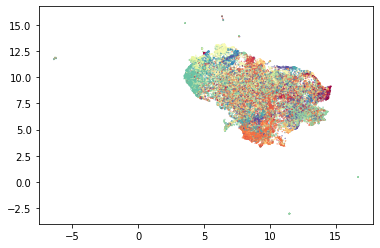

In [42]:
plt.scatter(vecs_umap2d[:, 0], vecs_umap2d[:, 1],
            c=subreddit_code, s=0.1, cmap='Spectral');

Looks like all embeddings are by-and-large lumped together, and/or the subreddit topics overlap a lot to begin with. 

Still, a few semi coherent monochrome lumps can be spotted. 

All in all, that's not an encouraging picture, but nonetheless lets see how far can we get with these embeddings. 

### cluster with HDBSCAN

In [43]:
from sklearn.metrics.pairwise import pairwise_distances

In [44]:
%%time
from sklearn.preprocessing import normalize

vecs_umap = normalize(vecs_umap, norm='l2')

CPU times: user 8.2 ms, sys: 4 µs, total: 8.21 ms
Wall time: 7.56 ms


In [45]:
%%time 
clusters = hdbscan.HDBSCAN(
    min_cluster_size = 200,
    metric='euclidean', 
    # cluster_selection_method='eom'
    ).fit_predict(vecs_umap)

CPU times: user 2.51 s, sys: 300 ms, total: 2.81 s
Wall time: 19.6 s


## Evaluate clusters against the given subreddits

In [46]:
print(f'# examples == {len(clusters)}')
vc = pd.value_counts(clusters)
print(f'# clusters == {len(vc)}')
vc

# examples == 37498
# clusters == 18


-1     21839
 1      3521
 14     2347
 4      2337
 2      2245
 6       738
 16      715
 8       482
 5       467
 10      411
 3       369
 7       368
 12      354
 15      328
 0       259
 13      249
 11      242
 9       227
dtype: int64

In [47]:
print(f'''First, we see that most posts could not be clustered (got a -1). 
That's too bad.
Among those that were clustered, we got 16 different clusters, while our data has {n_target_clusters} subreddits.
That's also too bad.
But lets see if those 16 caught any notion of the topic of the post.''')

First, we see that most posts could not be clustered (got a -1). 
That's too bad.
Among those that were clustered, we got 16 different clusters, while our data has 20 subreddits.
That's also too bad.
But lets see if those 16 caught any notion of the topic of the post.


Lets calc two of the most popular score for measuring the quality of a clustering. 

Scores close to zero are bad, close to 1 are good

In [48]:
(
    adjusted_rand_score(subreddit_code, clusters),
    adjusted_mutual_info_score(subreddit_code, clusters)
)

(0.042128969992828655, 0.20565319779378055)

Looks like we got bad scores. But scoring functions for clustering are often misleading. Let's eyeball the 

In [49]:
df['cluster'] = clusters
df


,author,body,created_utc,subreddit,id,score,body_clean,cluster
0,malcontent,&gt;The business cannot survive paying out ben...,2008-12-18 08:00:37,politics,2,1,The business cannot survive paying out benefi...,4
1,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:41,politics,3,1,"I'm curious, how do you see, beyond defining ...",-1
2,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:53,politics,4,2,"I'm curious, how do you see, beyond defining ...",-1
3,catalytica,The greatest historic instigator of human divi...,2008-12-18 08:01:20,atheism,7,0,The greatest historic instigator of human divi...,14
4,jz_,Looking forward to * writing more tests for m...,2008-12-18 08:01:24,programming,8,2,Looking forward to * writing more tests for m...,1
...,...,...,...,...,...,...,...,...
37493,[deleted],FEW... Good thing this vital research has bee...,2008-12-20 23:29:24,politics,1mt4,1,FEW... Good thing this vital research has bee...,-1
37494,m1ss1ontomars2k4,Where's the Tripod love?,2008-12-20 23:29:25,pics,1mt5,7,Where's the Tripod love?,-1
37495,[deleted],&gt; we're giving him money and credibility Y...,2008-12-20 23:29:27,WTF,1mt6,2,we're giving him money and credibility You ...,-1
37496,xlamplighter,"""Well, I reckon this Nazi Business has to end....",2008-12-20 23:29:44,WTF,1mtb,23,"""Well, I reckon this Nazi Business has to end....",-1


Lets use word clouds to eye ball how on-topic each cluster is

In [50]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

cluster #0


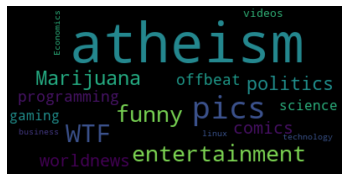

cluster #1


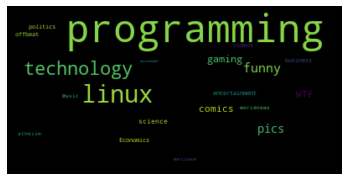

cluster #2


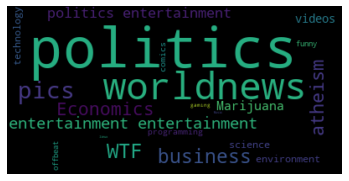

cluster #3


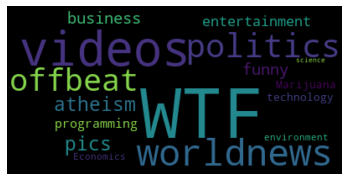

cluster #4


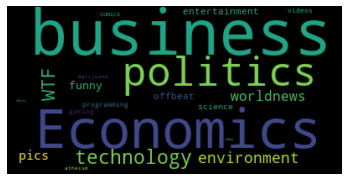

cluster #5


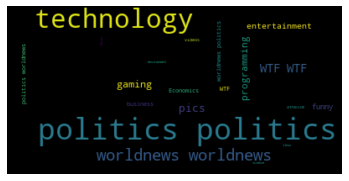

cluster #6


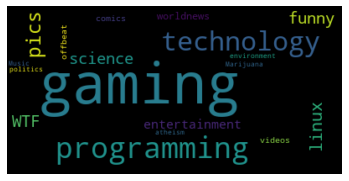

cluster #7


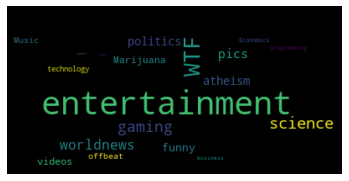

cluster #8


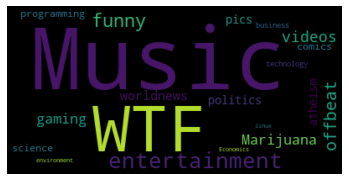

cluster #9


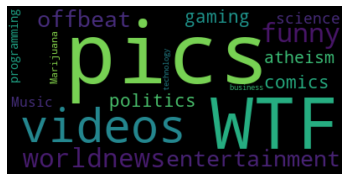

cluster #10


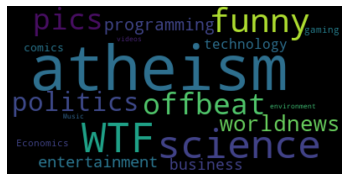

cluster #11


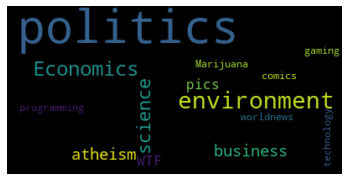

cluster #12


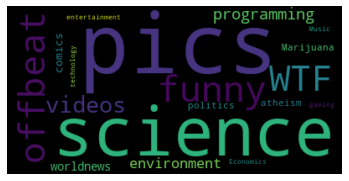

cluster #13


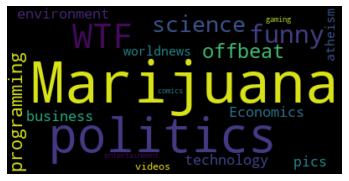

cluster #14


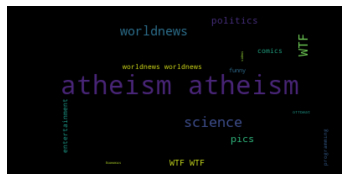

cluster #15


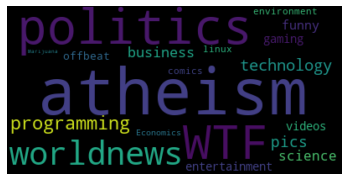

cluster #16


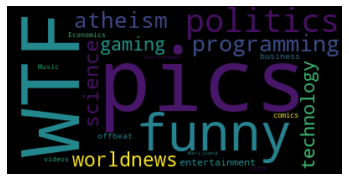

In [51]:
def plot_wordcloud(s, i):
  wordcloud = WordCloud().generate(s)

  # Display the generated image:
  print(f'cluster #{i}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

subreddits_by_cluster = df[df.cluster >= 0].groupby('cluster').agg({'subreddit': ' '.join}).subreddit.values   #apply(lambda s: plot_wordcloud)
for i, label_list in enumerate(subreddits_by_cluster):
  plot_wordcloud(label_list, i)

We can see that, 
1. there's a lot of noise, e.g. 'WTF' appears in several clusters, with no apparent connection to other topics in those clusters.
2. On the bright side, most of the clusters contain posts that share a coherent topic (according to their most salient subreddits). E.g., "worldnews and politics", "worldnews politics and canada", "Atheism and politics", "programming and linux", "gaming, technology, programming and entertainment", "music and entertainment". 

All in all, these results seem good enough for a first draft PoC, with no spare time for hyperparameter tuning, debugging, data curation, or other tweaking.



#  use these cluter-topics overtime to find interesting events in the data

## Look at days of a month

In [52]:
import plotly.express as px

In [53]:
def tally_clusters_by_date(small_df):
  small_df['date'] = small_df.created_utc.dt.date
  return small_df.groupby('date').agg({'cluster': len}).rename(columns={'cluster': 'cluster_count'})
  

df_tallied = df[df.cluster >= 0].groupby('cluster').apply(tally_clusters_by_date).reset_index()
df_tallied.head()

,cluster,date,cluster_count
0,0,2008-12-18,47
1,0,2008-12-19,96
2,0,2008-12-20,116
3,1,2008-12-18,968
4,1,2008-12-19,1525


In [54]:

fig = px.line(df_tallied, x='date', y='cluster_count', color='cluster', symbol="cluster")
fig.show()

Some observations:

1. looks like after xmas, ppl suddenly started posting a lot about  topic #2, which is about worldnews and politics, topic #14 (atheism, politics) and topic #12 (programming, technology).
2. topic #12 (programming, technology) is the most popular overall, and seems to be the most _weekly_, i.e., the traffic differene between working and non working days is the most pronounced. Most other topics get relatively higher traffic on days-off, and don't even dip on xmas. 
3. There seems to be a big surge in traffic about topics #12 (programming, tech)and #14 (atheism, politics) in the last full work week b4 xmas. maybe that's b/c ppl work more on that week, and also the more they work, the more they chat about politics??
4. topic #5 (business, economics) surges around 12 Dec, towards the end of the work week. Maybe ppl are doing some end of year bookkeeping or expenses, heh ?

## look at hours of a single work day

In [55]:
def tally_clusters_by_date(small_df):
  small_df['date'] = small_df.created_utc.dt.date
  return small_df.groupby('date').agg({'cluster': len}).rename(columns={'cluster': 'cluster_count'})
  

df_tallied = df[df.cluster >= 0].groupby('cluster').apply(tally_clusters_by_date).reset_index()
df_tallied.head()

,cluster,date,cluster_count
0,0,2008-12-18,47
1,0,2008-12-19,96
2,0,2008-12-20,116
3,1,2008-12-18,968
4,1,2008-12-19,1525


In [56]:

fig = px.line(df_tallied, x='date', y='cluster_count', color='cluster', symbol="cluster")
fig.show()